<a href="https://colab.research.google.com/github/JJGreen0/Binary-Classification-Weather/blob/main/AUS_WEATHER_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [ ]:
weather = pd.read_csv("weatherAUS.csv", index_col="Date")
mask = weather['Location'] == 'SydneyAirport'
weather = weather[mask]
weather = weather.drop(['RainTomorrow'], axis=1)

In [ ]:
weather["RainToday"].value_counts()

No     2231
Yes     774
Name: RainToday, dtype: int64

<ipython-input-4-57c8839c03c2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = weather.corr()


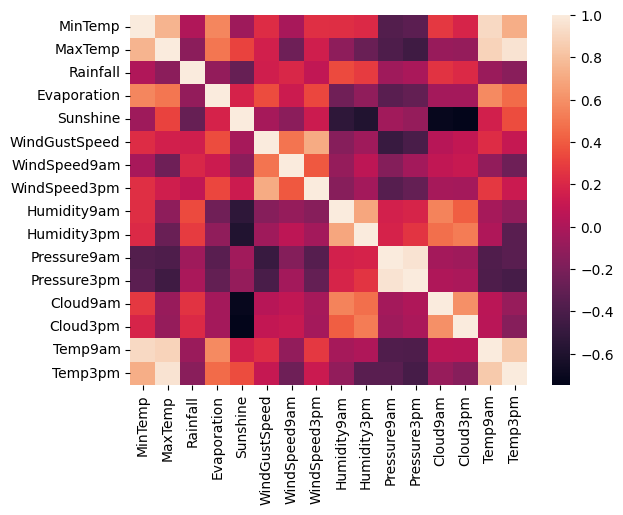

In [ ]:
corrmat = weather.corr()
corrmat
plot = sns.heatmap(corrmat)

In [ ]:
weather.drop(["Temp3pm","Pressure9am"],axis=1,inplace=True)

<ipython-input-6-57f24ea55c00>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=weather[col],kde=True)
<ipython-input-6-57f24ea55c00>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=weather[col],kde=True)
<ipython-input-6-57f24ea55c00>:7: UserWarning: 

`distplot` is a deprecated function a

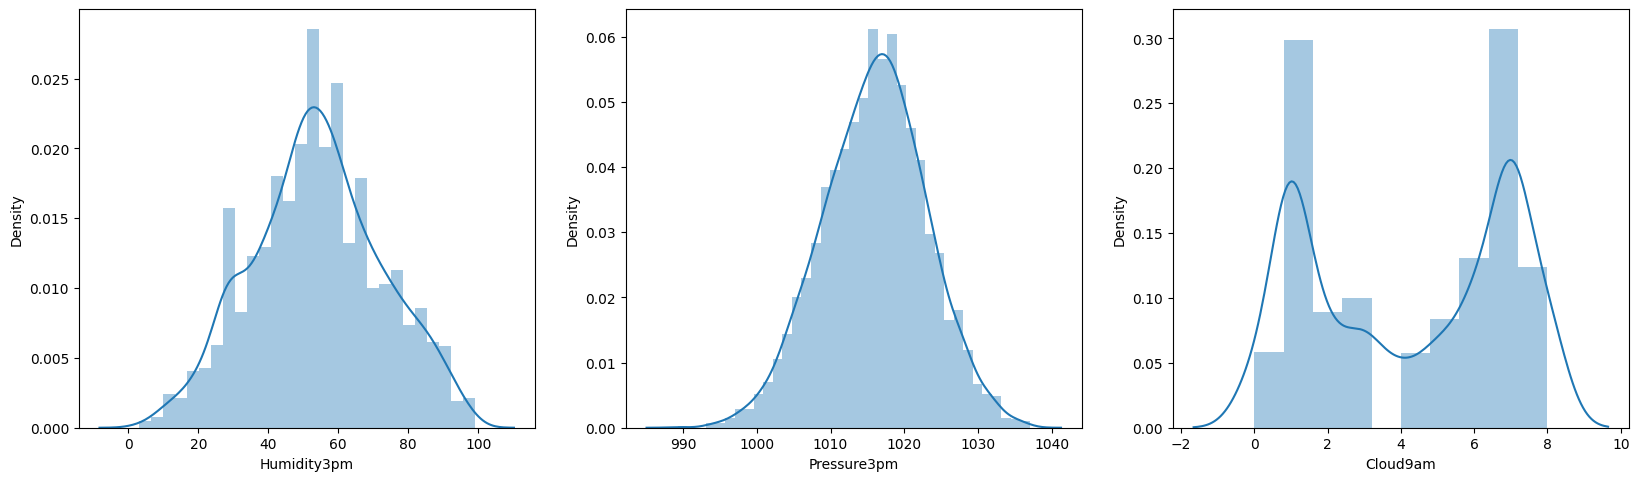

In [ ]:
columns=['Humidity3pm', 'Pressure3pm', 'Cloud9am']
plt.figure(figsize=(20,25))
plotnum = 1
for col in columns:
    if plotnum<11:
        plt.subplot(4,3,plotnum)
        sns.distplot(x=weather[col],kde=True)
        plt.xlabel(col)
    plotnum+=1
plt.show()

In [ ]:
weather["Pressure3pm"] = weather["Pressure3pm"].fillna(weather["Pressure3pm"].mean())
weather["Humidity3pm"] = weather["Humidity3pm"].fillna(weather["Humidity3pm"].mean())
weather["Temp9am"] = weather["Temp9am"].fillna(weather["Temp9am"].mean())
weather["MinTemp"] = weather["MinTemp"].fillna(weather["MinTemp"].mean())
weather["MaxTemp"] = weather["MaxTemp"].fillna(weather["MaxTemp"].mean())
weather["WindGustSpeed"] = weather["WindGustSpeed"].fillna(weather["WindGustSpeed"].mean())
weather["WindSpeed9am"] = weather["WindSpeed9am"].fillna(weather["WindSpeed9am"].median())
weather["WindSpeed3pm"] = weather["WindSpeed3pm"].fillna(weather["WindSpeed3pm"].mean())
weather["Humidity9am"] = weather["Humidity9am"].fillna(weather["Humidity9am"].mean())
weather["Humidity9am"] = weather["Humidity9am"].fillna(weather["Humidity9am"].mean())
weather["Cloud9am"] = weather["Cloud9am"].fillna(weather["Cloud9am"].mean())
weather["Evaporation"] = weather["Evaporation"].fillna(weather["Evaporation"].mean())
weather["Sunshine"] = weather["Sunshine"].fillna(weather["Sunshine"].mean())

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
nan_mask = weather['WindGustDir'].isna()
weather.loc[~nan_mask, 'WindGustDir'] = label_encoder.fit_transform(weather.loc[~nan_mask, 'WindGustDir'])

nan_mask = weather['WindDir9am'].isna()
weather.loc[~nan_mask, 'WindDir9am'] = label_encoder.fit_transform(weather.loc[~nan_mask, 'WindDir9am'])


nan_mask = weather['WindDir3pm'].isna()
weather.loc[~nan_mask, 'WindDir3pm'] = label_encoder.fit_transform(weather.loc[~nan_mask, 'WindDir3pm'])

nan_mask = weather['RainToday'].isna()
weather.loc[~nan_mask, 'RainToday'] = label_encoder.fit_transform(weather.loc[~nan_mask, 'RainToday'])

In [ ]:
knnimp = KNNImputer(n_neighbors=5,metric='nan_euclidean')
knnimp.fit(weather["WindGustDir"].values.reshape(-1, 1))
weather["WindGustDir"]  = knnimp.transform(weather["WindGustDir"].values.reshape(-1, 1))

knnimp.fit(weather["WindDir9am"].values.reshape(-1, 1))
weather["WindDir9am"]  = knnimp.transform(weather["WindDir9am"].values.reshape(-1, 1))

knnimp.fit(weather["WindDir3pm"].values.reshape(-1, 1))
weather["WindDir3pm"]  = knnimp.transform(weather["WindDir3pm"].values.reshape(-1, 1))


In [ ]:
weather["Rainfall"] = weather["Rainfall"].fillna(0.0)
weather["RainToday"] = weather["RainToday"].fillna(0)

In [ ]:
weather.index = pd.to_datetime(weather.index)

In [ ]:
rf = RandomForestClassifier(n_estimators=73, min_samples_split=10, random_state=1)
train = weather.loc[:'2015-01-01']
test = weather.loc['2015-01-01':]
predictors = ["MinTemp",
              "MaxTemp",
              "Evaporation",
              "Sunshine",
              "WindGustDir",
              "WindGustSpeed",
              "WindDir9am",
              "WindDir3pm",
              "WindSpeed9am",
              "WindSpeed3pm",
              "Humidity9am",
              "Humidity3pm",
              "Pressure3pm",
              "Cloud9am",
              "Temp9am"]

In [ ]:
def rolling_averages(group, cols, new_cols):
  group = group.sort_values("Date")
  rolling_stats = group[cols].rolling(1, closed = "left").mean()
  group[new_cols] = rolling_stats
  group = group.dropna(subset=new_cols)
  return group

In [ ]:
cols = predictors + ["Rainfall"]
new_cols = [f"{c}_rolling" for c in cols]

In [ ]:
weather_rolling = rolling_averages(weather, cols, new_cols)
weather_rolling

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindDir9am_rolling,WindDir3pm_rolling,WindSpeed9am_rolling,WindSpeed3pm_rolling,Humidity9am_rolling,Humidity3pm_rolling,Pressure3pm_rolling,Cloud9am_rolling,Temp9am_rolling,Rainfall_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,SydneyAirport,18.5,23.0,0.0,11.0,5.9,8.000000,63.00000,10.0,9.0,...,7.0,7.0,15.0,33.0,63.0,13.0,1000.2,6.0,22.9,0.0
2009-01-03,SydneyAirport,16.9,23.2,0.0,9.0,0.5,7.946924,47.23428,2.0,1.0,...,10.0,9.0,15.0,35.0,63.0,58.0,1014.1,5.0,20.6,0.0
2009-01-04,SydneyAirport,18.7,27.1,0.0,5.4,11.3,4.000000,65.00000,5.0,4.0,...,2.0,1.0,15.0,17.0,52.0,50.0,1019.4,7.0,18.9,0.0
2009-01-05,SydneyAirport,20.2,31.6,0.0,10.0,12.2,5.000000,63.00000,14.0,4.0,...,5.0,4.0,24.0,48.0,60.0,51.0,1014.9,2.0,22.9,0.0
2009-01-06,SydneyAirport,19.9,29.7,0.0,10.0,11.8,4.000000,41.00000,8.0,0.0,...,14.0,4.0,11.0,35.0,58.0,52.0,1008.0,6.0,24.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-21,SydneyAirport,8.6,18.6,0.2,2.0,7.8,11.000000,56.00000,6.0,8.0,...,14.0,10.0,13.0,13.0,88.0,71.0,1025.2,6.0,14.0,1.6
2017-06-22,SydneyAirport,9.5,17.8,0.2,2.0,9.2,12.000000,35.00000,6.0,10.0,...,6.0,8.0,13.0,28.0,69.0,67.0,1025.3,2.0,13.3,0.2
2017-06-23,SydneyAirport,8.7,19.4,0.0,2.4,2.7,6.000000,30.00000,7.0,7.0,...,6.0,10.0,9.0,9.0,74.0,70.0,1024.6,2.0,14.3,0.2


In [ ]:
def make_predictions(data, predictors):
  train = data.loc[:'2015-01-01']
  test = data.loc['2015-01-01':]
  rf.fit(train[predictors], train["RainToday"])
  preds = rf.predict(test[predictors])
  combine = pd.DataFrame(dict(actual=test["RainToday"], predicted=preds), index=test.index)
  precision = precision_score(test["RainToday"], preds)
  acc = accuracy_score(test["RainToday"], preds)
  recall = recall_score(test["RainToday"], preds)
  MCC = matthews_corrcoef(test["RainToday"], preds)
  return combine, precision, acc, recall,  MCC

In [ ]:
combine, precision, acc, recall, MCC = make_predictions(weather_rolling, predictors + new_cols)

<Axes: xlabel='predicted', ylabel='actual'>

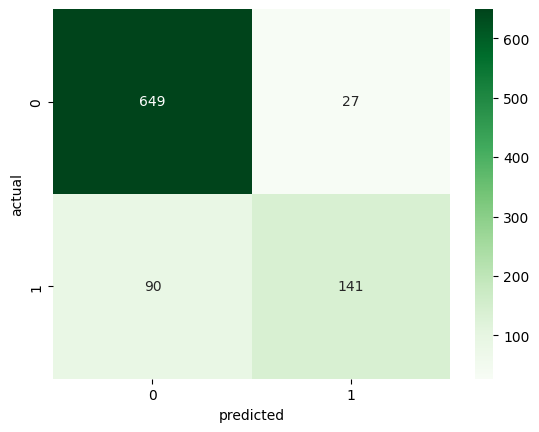

In [ ]:
cm = pd.crosstab(index=combine["actual"], columns=combine["predicted"])
sns.heatmap(cm, cmap="Greens", annot=True, fmt="d")

In [ ]:
precision

0.8392857142857143

In [ ]:
acc

0.8710033076074972

In [ ]:
recall

0.6103896103896104

In [ ]:
MCC

0.6397630228375037

In [ ]:
len(predictors + new_cols)

31

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

classifier.add(Dense(units = 15, activation = 'relu', input_dim = len(predictors + new_cols)))
classifier.add(Dropout((1.5/60)))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])

In [ ]:
len(predictors + new_cols)

NameError: ignored

In [ ]:
def make_predictionsNN(data, predictors):
  train = data.loc[:'2015-01-01']
  test = data.loc['2015-01-01':]
  history = classifier.fit(train[predictors], train["RainToday"], epochs = 300, batch_size = 50, validation_split = 0.2)
  preds = classifier.predict(test[predictors])
  preds = [ 1 if y>=0.5 else 0 for y in preds]
  combine = pd.DataFrame(dict(actual=test["RainToday"], predicted=preds), index=test.index)
  precision = precision_score(test["RainToday"], preds)
  acc = accuracy_score(test["RainToday"], preds)
  recall = recall_score(test["RainToday"], preds)
  MCC = matthews_corrcoef(test["RainToday"], preds)
  return combine, precision, acc, recall,  MCC, history

combine, precision, acc, recall, MCC, history = make_predictionsNN(weather_rolling, predictors + new_cols)

Epoch 1/300
34/34 [==============================] - 1s 8ms/step - loss: 19.8022 - accuracy: 0.6514 - val_loss: 3.4752 - val_accuracy: 0.7316
Epoch 2/300
34/34 [==============================] - 0s 3ms/step - loss: 4.0380 - accuracy: 0.6330 - val_loss: 0.9841 - val_accuracy: 0.7031
Epoch 3/300
34/34 [==============================] - 0s 3ms/step - loss: 2.5580 - accuracy: 0.6550 - val_loss: 0.6306 - val_accuracy: 0.7007
Epoch 4/300
34/34 [==============================] - 0s 4ms/step - loss: 2.5824 - accuracy: 0.6907 - val_loss: 0.6514 - val_accuracy: 0.7340
Epoch 5/300
34/34 [==============================] - 0s 3ms/step - loss: 1.7830 - accuracy: 0.7073 - val_loss: 0.5568 - val_accuracy: 0.7292
Epoch 6/300
34/34 [==============================] - 0s 3ms/step - loss: 1.7975 - accuracy: 0.7032 - val_loss: 0.5340 - val_accuracy: 0.7411
Epoch 7/300
34/34 [==============================] - 0s 3ms/step - loss: 1.6600 - accuracy: 0.7079 - val_loss: 0.6598 - val_accuracy: 0.7316
Epoch 8/300


In [ ]:
cm = pd.crosstab(index=combine["actual"], columns=combine["predicted"])
cm

predicted,0,1
actual,,
0,632,44
1,75,156


<Axes: xlabel='predicted', ylabel='actual'>

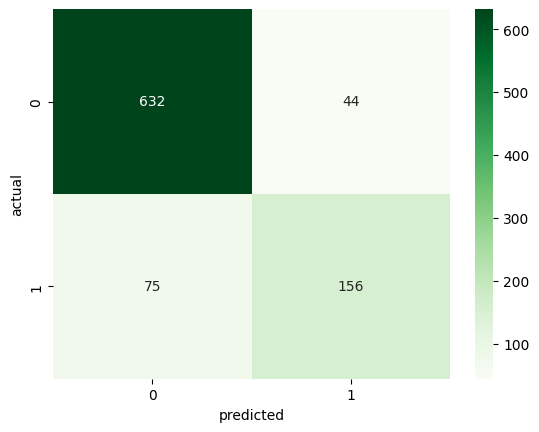

In [ ]:
sns.heatmap(cm, cmap="Greens", annot=True, fmt="d")

In [ ]:
precision

0.78

In [ ]:
acc

0.8687982359426681

In [ ]:
recall

0.6753246753246753

In [ ]:
MCC

0.6412869458338158

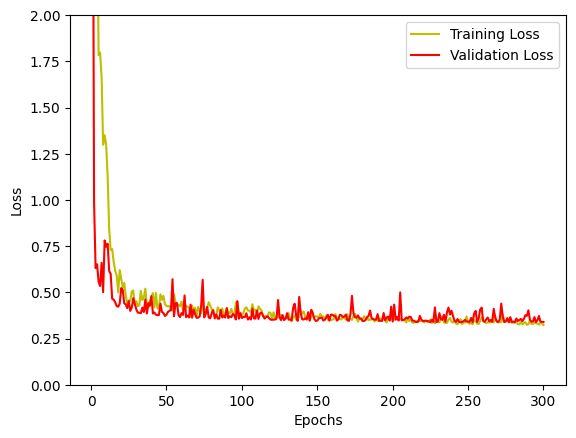

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = "Training Loss")
plt.plot(epochs, val_loss, 'r', label = "Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 2])
plt.show()

In [ ]:
import keras
table = []
table2 = []
for i in range(1,20):
  classifier = Sequential()
  classifier.add(Dense(units = 15, activation = 'relu', input_dim = len(predictors + new_cols)))
  classifier.add(Dropout((1+(0.1*i))/60))
  classifier.add(Dense(units = 15, activation = 'relu'))
  classifier.add(Dense(units = 15, activation = 'relu'))
  classifier.add(Dense(units = 1, activation = 'sigmoid'))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy')
  data = weather_rolling
  predictors2 = predictors + new_cols
  train = data.loc[:'2015-01-01']
  test = data.loc['2015-01-01':]
  history = classifier.fit(train[predictors2], train["RainToday"], epochs = 100, batch_size = 20, validation_split = 0.2)
  preds = classifier.predict(test[predictors2])
  preds = [ 1 if y>=0.5 else 0 for y in preds]
  MCC = matthews_corrcoef(test["RainToday"], preds)
  print(i)
  print(MCC)
  table.append(MCC)
table2.append(max(table))
table

Epoch 1/100
85/85 [==============================] - 2s 4ms/step - loss: 7.5194 - val_loss: 1.3284
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 2.5894 - val_loss: 2.0329
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 2.0145 - val_loss: 0.7211
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 1.2471 - val_loss: 0.9856
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 1.4350 - val_loss: 0.7572
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 1.2276 - val_loss: 0.6148
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 1.0018 - val_loss: 0.6014
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.9276 - val_loss: 1.0248
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.8188 - val_loss: 0.4785
Epoch 10/100
85/85 [==============================] - 0s 3ms/step - loss: 0.8684 - val_loss: 0.4421
Epoch 11/

KeyboardInterrupt: ignored

In [ ]:
table

[0.6487807326521342]